In [1]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.metrics import f1_score

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        out = self.relu(out)
        return out

class AudioClassificationModel(nn.Module):
    def __init__(self):
        super(AudioClassificationModel, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(1024, 6) for _ in range(9)])
        
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(54 if i == 0 else 120, 120, kernel_size=3, stride=2 if i == 0 else 1) for i in range(12)]
        )
        
        # Placeholder for flattened size, to be dynamically determined
        self.flattened_size = None
        self.fc = None  # Placeholder for the fully connected layers, to be initialized once flattened size is known
        
    def forward(self, x):
        embedded_rows = []
        for i in range(9):
            row = x[:, i, :]
            embedded_row = self.embeddings[i](row)
            embedded_row = embedded_row.transpose(1, 2)
            embedded_rows.append(embedded_row)
        
        embedded_output = torch.stack(embedded_rows, dim=1)
        embedded_output = embedded_output.reshape(x.shape[0], 54, -1)
        
        res_output = self.res_blocks(embedded_output)
        res_output = res_output.view(res_output.size(0), -1)
        
        # Dynamically determine and initialize the fully connected layer if not already done
        if self.fc is None:
            self.flattened_size = res_output.shape[1]
            self.fc = nn.Sequential(
                nn.Linear(self.flattened_size, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 24)  # Output layer for 24 classes
            ).to(res_output.device)  # Ensure the new layers are on the correct device
        
        output = self.fc(res_output)
        return output


In [3]:
dataset = load_dataset("danjacobellis/audio_har_descript_44kHz_frames_900",split='train').with_format("torch",device="cuda")
model = AudioClassificationModel().to("cuda")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

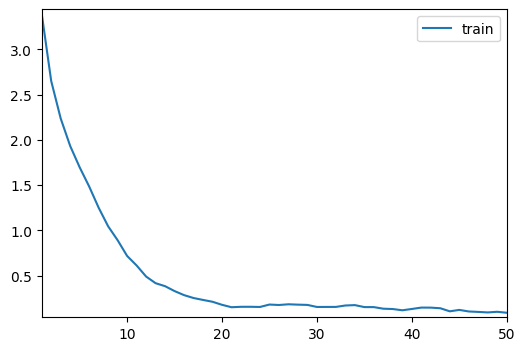

In [4]:
epochs = 50
mb = master_bar(range(1, epochs + 1))
train_loss = []

for epoch in mb:
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
    model.train()
    running_loss = 0.0
    for inputs in progress_bar(dataloader, parent=mb):
        codes = inputs['codes'].to(torch.int64)
        targets = inputs['label']
        one_hot_targets = F.one_hot(targets, num_classes=24).to(torch.float)

        optimizer.zero_grad()
        outputs = model(codes)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    train_loss.append(epoch_loss)

    mb.write(f'Epoch {epoch}: Train Loss: {epoch_loss:.4f}')
    
    graphs = [[range(1, epoch + 1), train_loss]]
    x_bounds = [1, epochs]
    y_bounds = [min(train_loss) - 0.05, max(train_loss) + 0.05]
    mb.update_graph(graphs, x_bounds, y_bounds)

In [5]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs in dataloader:
        codes = inputs['codes'].to(torch.int64)
        targets = inputs['label']
        true_labels.extend(targets.cpu().numpy())
        outputs = model(codes)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f'Accuracy on the training set: {accuracy * 100:.2f}%')

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score on the training set: {f1:.2f}')

Accuracy on the training set: 100.00%
F1 Score on the training set: 1.00


In [ ]:
participants = set(dataset['participant'].unique())

results = []

for test_participant in participants:
    print(f"Training excluding Participant {test_participant}")
    train_indices = [i for i, p in enumerate(dataset['participant']) if p != test_participant]
    test_indices = [i for i, p in enumerate(dataset['participant']) if p == test_participant]
    train_data = dataset.select(train_indices)
    test_data = dataset.select(test_indices)
    model = AudioClassificationModel().to("cuda")
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(1, epochs + 1):
        train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
        model.train()
        running_loss = 0.0
        for inputs in train_dataloader:
            codes = inputs['codes'].to(torch.int64)
            targets = inputs['label']
            one_hot_targets = F.one_hot(targets, num_classes=24).to(torch.float)
            optimizer.zero_grad()
            outputs = model(codes)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch {epoch}/{epochs}, Participant {test_participant}: Loss = {epoch_loss:.4f}')
    
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs in test_dataloader:
            codes = inputs['codes'].to(torch.int64)
            targets = inputs['label']
            true_labels.extend(targets.cpu().numpy())
            outputs = model(codes)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'LOPO Test Participant {test_participant}: Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.2f}')
    results.append((test_participant, accuracy, f1))

Training excluding Participant 2
Epoch 1/50, Participant 2: Loss = 3.4769
Epoch 2/50, Participant 2: Loss = 2.8007
Epoch 3/50, Participant 2: Loss = 2.3472
Epoch 4/50, Participant 2: Loss = 2.0043
Epoch 5/50, Participant 2: Loss = 1.6988
Epoch 6/50, Participant 2: Loss = 1.4128
Epoch 7/50, Participant 2: Loss = 1.1896
Epoch 8/50, Participant 2: Loss = 0.9857
Epoch 9/50, Participant 2: Loss = 0.8154
Epoch 10/50, Participant 2: Loss = 0.6439
Epoch 11/50, Participant 2: Loss = 0.5225
Epoch 12/50, Participant 2: Loss = 0.4404
Epoch 13/50, Participant 2: Loss = 0.3715
Epoch 14/50, Participant 2: Loss = 0.3219
Epoch 15/50, Participant 2: Loss = 0.2613
Epoch 16/50, Participant 2: Loss = 0.2424
Epoch 17/50, Participant 2: Loss = 0.2164
Epoch 18/50, Participant 2: Loss = 0.2010
Epoch 19/50, Participant 2: Loss = 0.2054
Epoch 20/50, Participant 2: Loss = 0.1917
Epoch 21/50, Participant 2: Loss = 0.1700
Epoch 22/50, Participant 2: Loss = 0.1636
Epoch 23/50, Participant 2: Loss = 0.1561
Epoch 24/5